In [1]:
import json
import pandas as pd 

df = pd.read_csv('/Users/marynelson/Downloads/dataset_website-content-crawler_2024-06-28_18-27-59-923.csv')

# print(df1.shape)

# Concatenate DataFrames
# df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
df.head()
print(df.shape)


(55, 103)


In [2]:
from datetime import datetime
# Function to calculate time since modified date
def time_since_modified(modified_date_str):
    if not isinstance(modified_date_str, str):
        return None
    if isinstance(modified_date_str, str):
        modified_date = datetime.strptime(modified_date_str, "%Y-%m-%dT%H:%M:%S%z")
        current_date = datetime.now(modified_date.tzinfo)  # Ensure the same timezone
        time_difference = current_date - modified_date
        return time_difference.days

# Apply function to the DataFrame
df['days_since_modified'] = df['metadata/jsonLd/0/@graph/0/dateModified'].apply(lambda x: time_since_modified(x))


print(df.shape)

(55, 104)


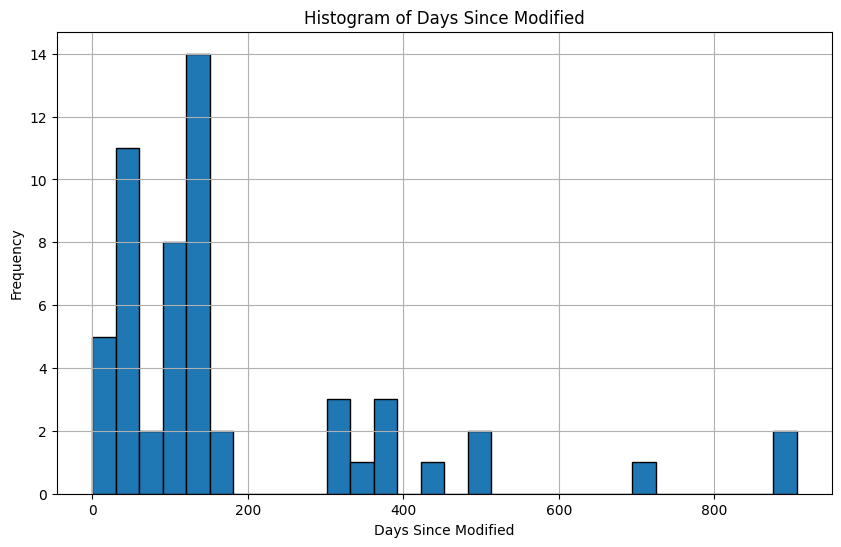

In [3]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['days_since_modified'], bins=30, edgecolor='black')
plt.title('Histogram of Days Since Modified')
plt.xlabel('Days Since Modified')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [4]:
import re
# Function to calculate content metrics
def calculate_content_metrics(markdown):
        # Replace URLs with a placeholder
    url_placeholder = "URL_PLACEHOLDER"
    urls = re.findall(r'https?://[^\s]+', markdown)
    for url in urls:
        markdown = markdown.replace(url, url_placeholder)
        
    word_count = len(markdown.split())
    sentence_count = len(re.split(r'[.!?]+', markdown))
    char_count = len(markdown)
    average_word_length = sum(len(word) for word in markdown.split()) / word_count
    average_sentence_length = word_count / sentence_count if sentence_count else 0
    header_count = markdown.count('#')
    list_count = len(re.findall(r'^[*-]\s', markdown, re.MULTILINE))
    link_count = len(re.findall(r'\[.*?\]\(.*?\)', markdown))
    return pd.Series([word_count, sentence_count, char_count, average_word_length, average_sentence_length, header_count, list_count, link_count])
# Apply function to the DataFrame
df[['word_count', 'sentence_count', 'char_count', 'average_word_length', 'average_sentence_length', 'header_count', 'list_count', 'link_count']] = df['markdown'].apply(calculate_content_metrics)
print(df.shape)

(55, 112)


In [5]:
df = df.sort_values(by='days_since_modified', ascending=False)
print(len(df))

55


In [6]:
def sentence_count_class(sc):
    if sc < 5:
        return 0
    elif sc < 20:
        return 1
    elif sc > 50:
        return 2
    else:
        return 0
    
df['sentence_count_class'] = df['sentence_count'].apply(sentence_count_class)


In [7]:
def age_class(age):
    if age < 365:
        return 2
    elif age < 720:
        return 1
    else:
        return 0
    
df['age_class'] = df['days_since_modified'].apply(age_class)

In [8]:
# Drop duplicates, keeping the first occurrence and removing subsequent duplicates
df= df.drop_duplicates(subset=['markdown'], keep='first')

# Display the DataFrame without duplicates
df.head()
print(df.shape)

(55, 114)


In [10]:
import tldextract
from urllib.parse import urlparse

def extract_parts(url):
    extracted = tldextract.extract(url)
    subdomain = extracted.subdomain if extracted.domain == "indianatech" and extracted.suffix == "edu" else None

    # Extract the first path item
    parsed_url = urlparse(url)
    path_parts = parsed_url.path.strip('/').split('/')
    first_path_item = path_parts[0] if path_parts else None
    second_path_item = path_parts[1] if len(path_parts) > 1 else None
    link_depth = len(path_parts)
    
    return pd.Series([subdomain, first_path_item, second_path_item, link_depth])

# Apply function to the DataFrame
df[['subdomain', 'first_path_item', 'second_path_item', 'link_depth']] = df['metadata/canonicalUrl'].apply(lambda x: extract_parts(x))

# Display the updated DataFrame
df.head()
print(df.shape)

(55, 118)


In [11]:
def link_depth_class(link_depth):
    if link_depth < 2:
        return 2
    elif link_depth == 2:
        return 1
    elif link_depth> 2:
        return 0
    else:
        return 0
    
df['link_depth_class'] = df['link_depth'].apply(link_depth_class)

In [12]:
# List all columns
columns = df.columns.tolist()
print(columns)

['markdown', 'metadata/author', 'metadata/canonicalUrl', 'metadata/description', 'metadata/headers/access-control-allow-origin', 'metadata/headers/cache-control', 'metadata/headers/connection', 'metadata/headers/content-encoding', 'metadata/headers/content-length', 'metadata/headers/content-type', 'metadata/headers/date', 'metadata/headers/etag', 'metadata/headers/link', 'metadata/headers/server', 'metadata/headers/strict-transport-security', 'metadata/headers/transfer-encoding', 'metadata/headers/vary', 'metadata/headers/x-firefox-spdy', 'metadata/jsonLd/0/@context', 'metadata/jsonLd/0/@graph/0/@id', 'metadata/jsonLd/0/@graph/0/@type', 'metadata/jsonLd/0/@graph/0/breadcrumb/@id', 'metadata/jsonLd/0/@graph/0/dateModified', 'metadata/jsonLd/0/@graph/0/datePublished', 'metadata/jsonLd/0/@graph/0/description', 'metadata/jsonLd/0/@graph/0/image/@id', 'metadata/jsonLd/0/@graph/0/inLanguage', 'metadata/jsonLd/0/@graph/0/isPartOf/@id', 'metadata/jsonLd/0/@graph/0/name', 'metadata/jsonLd/0/@gr

In [13]:
import tiktoken

def split_markdown_content(df, token_limit=5000, overlap_ratio=0.2):
    # Initialize the tokenizer
    enc = tiktoken.get_encoding('cl100k_base')  # Use the appropriate encoding

    def split_content(content):
        tokens = enc.encode(content)
        token_count = len(tokens)

        if token_count <= token_limit:
            return [content]

        chunk_size = int(token_limit * (1 - overlap_ratio))
        overlap_size = int(token_limit * overlap_ratio)
        chunks = []

        start = 0
        while start < token_count:
            end = start + token_limit
            chunk_tokens = tokens[start:end]
            chunk_text = enc.decode(chunk_tokens)
            chunks.append(chunk_text)
            start += chunk_size

        return chunks

    new_rows = []
    for _, row in df.iterrows():
        markdown_content = row['markdown']
        chunks = split_content(markdown_content)
        for chunk in chunks:
            new_row = row.copy()
            new_row['markdown'] = chunk
            new_rows.append(new_row)

    new_df = pd.DataFrame(new_rows)
    return new_df

df = split_markdown_content(df)
print(df.shape)

(56, 119)


In [14]:
# Exporting DataFrame to a CSV file
print(df.shape)
df.to_csv('itech_processed.csv', index=False)

(56, 119)
